# Analysis of Tesla PAB

This jupyter notebook presents the data along with the calculations for added transparency. Section 1 will read the data and create functions and plots, while [Section 2](#results) will show the data and plots.

To run all the cells, click **Kernel** > **Restart and Run All**.

Each cell can be run individually with **Shift + Enter**.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 1 Preparation

### 1.1 Python Packages

Pandas will be used for manipulating the excel table data, while seaborn will help with displaying the plots.

In [2]:
import os
import pandas as pd
import seaborn as sns
sns.set(font_scale=2)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
from scipy import stats
from datetime import datetime, timedelta
# %matplotlib notebook
# https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916 

Next we read the excel sheets representing the front, and side data results from the MLCT program. We'll extract just the columns we need with the double brackets, then display the first 5 rows of the front dataframe (front_df).

In [3]:
# read excel sheets for AOA data
# front_aoa_df = pd.read_excel(r'data/front_data.xlsx', index_col='completed')[['Frame', 'sample', 'Raw Score']]
# side_aoa_df = pd.read_excel(r'data/side_data.xlsx', index_col='completed')[['Frame', 'sample', 'Raw Score']]
# acs_df_1 = pd.read_csv(r'data/ACS_Results1.csv')
# acs_df_2 = pd.read_csv(r'data/ACS_Results2.csv')
# aoa_df = pd.read_csv(r'data/AOA_Results.csv')
acs_df_1 = pd.read_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\ACS MLCT Scores 1.xlsx')
acs_df_2 = pd.read_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\ACS MLCT Scores 2 redo.xlsx')
aoa_df =   pd.read_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\AOA MLCT Scores redo.xlsx')
acs_df_1_r = pd.read_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\ACS Ranking 1.xlsx')
acs_df_2_r = pd.read_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\ACS Ranking 2.xlsx')
aoa_df_r = pd.read_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\AOA Ranking 1.xlsx')

# Rename index column
# front_aoa_df.index.name = 'Date'
# side_aoa_df.index.name = 'Date'
acs_df_1['Date1'] = pd.to_datetime(acs_df_1['File_name'].apply(lambda x: x.split('_')[2]))
# acs_df_1.set_index('Date', inplace=True)
acs_df_2['Date1'] = pd.to_datetime(acs_df_2['File_name'].apply(lambda x: x.split('_')[2]))
# acs_df_2.set_index('Date', inplace=True)
aoa_df['Date1'] = pd.to_datetime(aoa_df['File_name'].apply(lambda x: x.split('_')[2]))
# aoa_df.set_index('Date', inplace=True)
acs_df_1_r['Date'] = pd.to_datetime(acs_df_1_r['Date'])
acs_df_2_r['Date'] = pd.to_datetime(acs_df_2_r['Date'])
aoa_df_r['Date'] = pd.to_datetime(aoa_df_r['Date'])

# Extract frame
acs_df_1['Frame'] = acs_df_1['File_name'].apply(lambda x: x.split('_')[-1].split('.')[0].split('side')[1]).astype(int)
acs_df_2['Frame'] = acs_df_2['File_name'].apply(lambda x: x.split('_')[-1].split('.')[0].split('side')[1]).astype(int)
aoa_df['Frame'] = aoa_df['File_name'].apply(lambda x: x.split('_')[-1].split('.')[0].split('side')[1]).astype(int)

# Add raw score column
acs_df_1['Raw Score'] = acs_df_1['Score']
acs_df_2['Raw Score'] = acs_df_2['Score']
aoa_df['Raw Score'] = aoa_df['Score']

# Add facility column
acs_df_1['Facility'] = 'ACS'
acs_df_2['Facility'] = 'ACS'
aoa_df['Facility'] = 'AOA'

# Add group column
acs_df_1['Group'] = 'ACS1'
acs_df_2['Group'] = 'ACS2'
aoa_df['Group'] = 'AOA'

def add_sigma(df):
    mean = df['Raw Score'].mean()
    std = df['Raw Score'].std()
    df['sigma'] = (df['Raw Score'] - mean) / std
    return df

# Add sigma values for MLCT scores
acs_df_1 = add_sigma(acs_df_1)
acs_df_2 = add_sigma(acs_df_2)
aoa_df = add_sigma(aoa_df)

# Combine on sample ids
def combine_sample_ids(mlct_df, rank_df):
    mlct_df['last4'] = mlct_df['File_name'].apply(lambda x: x.split('_')[4][-4:])
    df = pd.merge(mlct_df, rank_df, left_on='last4', right_on='Sample')
    return df
# Remove null columns
# aoa_df.drop(columns='Unnamed: 0', axis=0)
# front_aoa_df = front_aoa_df.iloc[7:]
# side_aoa_df = side_aoa_df.iloc[7:]

# Merge mlct and troy rankings
acs_df_1_c = combine_sample_ids(acs_df_1, acs_df_1_r)
acs_df_2_c = combine_sample_ids(acs_df_2, acs_df_2_r)
aoa_df_c = combine_sample_ids(aoa_df, aoa_df_r)
this_df_c = pd.concat([aoa_df_c, acs_df_1_c, acs_df_2_c])
# this_df_c = pd.concat([aoa_df_c, acs_df_1_c])
this_df_c = this_df_c.reset_index()

# Add noisy rank column
this_df_c['Rank_noisy'] = this_df_c['Rank'] + np.random.normal(0, 0.15, len(this_df_c))

# Extract only important rows
# this_df_c = this_df_c[this_df_c['Frame'] == 18]
this_df = this_df_c[['Raw Score', 'sigma', 'Group', 'Facility', 'Date', 'Rank', 'Rank_noisy']]
this_df_c

,index,Unnamed: 0,File_name,Score,Frame,File_Path,notification_limit,Pass,frm_name,Date1,...,Group,sigma,last4,Index,Rank,partnumber,Date,Temp,Sample,Rank_noisy
0,0,0,cropped_6558541-00CB7K-42-S_20Jul2021_Hot_CS65...,2781.285870,14,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tes...,2944.673499,True,CS656175421057AAQX_Side,2021-07-20,...,AOA,1.936305,AAQX,2,1,6558541,2021-07-20,Hot,AAQX,1.055962
1,1,0,cropped_6558541-00CB7K-42-S_20Jul2021_Hot_CS65...,3518.650209,16,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tes...,2430.271726,False,CS656175421057AAQX_Side,2021-07-20,...,AOA,2.913778,AAQX,2,1,6558541,2021-07-20,Hot,AAQX,1.153196
2,2,0,cropped_6558541-00CB7K-42-S_20Jul2021_Hot_CS65...,4412.054468,18,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tes...,2808.801109,False,CS656175421057AAQX_Side,2021-07-20,...,AOA,4.098101,AAQX,2,1,6558541,2021-07-20,Hot,AAQX,1.253888
3,3,0,cropped_6558541-00CB7K-42-S_20Jul2021_Hot_CS65...,4222.721554,20,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tes...,2569.668283,False,CS656175421057AAQX_Side,2021-07-20,...,AOA,3.847116,AAQX,2,1,6558541,2021-07-20,Hot,AAQX,0.924585
4,4,0,cropped_6558541-00CB7K-42-S_20Jul2021_Hot_CS65...,4017.490087,22,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tes...,2734.263758,False,CS656175421057AAQX_Side,2021-07-20,...,AOA,3.575055,AAQX,2,1,6558541,2021-07-20,Hot,AAQX,1.183356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,2755,0,cropped_641046811DF0_25Dec2021_HT_P1077824-CN-...,2387.328926,16,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tel...,6836.408125,True,P1077824-CN-F-SCZ62135853DBKP0_Side,2021-12-25,...,ACS2,0.159126,BKP0,129,3,641046811DF0,2021-12-25,Hot,BKP0,3.178953
4142,2756,0,cropped_641046811DF0_25Dec2021_HT_P1077824-CN-...,2127.266129,18,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tel...,5734.271731,True,P1077824-CN-F-SCZ62135853DBKP0_Side,2021-12-25,...,ACS2,-0.125963,BKP0,129,3,641046811DF0,2021-12-25,Hot,BKP0,3.186770
4143,2757,0,cropped_641046811DF0_25Dec2021_HT_P1077824-CN-...,2591.701816,20,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tel...,5350.750169,True,P1077824-CN-F-SCZ62135853DBKP0_Side,2021-12-25,...,ACS2,0.383166,BKP0,129,3,641046811DF0,2021-12-25,Hot,BKP0,2.952223
4144,2758,0,cropped_641046811DF0_25Dec2021_HT_P1077824-CN-...,2605.454864,22,C:\Temp\MLCT\Temp_auto_ACS\template_images\Tel...,4784.334488,True,P1077824-CN-F-SCZ62135853DBKP0_Side,2021-12-25,...,ACS2,0.398242,BKP0,129,3,641046811DF0,2021-12-25,Hot,BKP0,3.010642


In [4]:
this_df_c['Date'] = pd.to_datetime(this_df_c['Date']).dt.strftime('%Y-%m-%d')
this_df_c['Part Number'] = this_df_c['partnumber']
this_df_c['Frame (ms)'] = this_df_c['Frame']
this_df_c['Sample ID'] = this_df_c['frm_name'].apply(lambda x: x.split('_')[0])
this_df_c['MLCT Error Score'] = this_df_c['Score']
this_df_c['MLCT Std Error Score'] = this_df_c['sigma']
this_df_c['TS Rank'] = this_df_c['Rank']
this_df = this_df_c[['Date', 'Facility', 'Group', 'Part Number', 'Frame (ms)', 'Sample ID', 'MLCT Error Score', 'MLCT Std Error Score', 'TS Rank', 'Rank_noisy']]
# this_df.to_excel(r'C:\Temp\MLCT\Tesla PAB Videos\Analysis\TeslaAnalysis.xlsx', index=False)

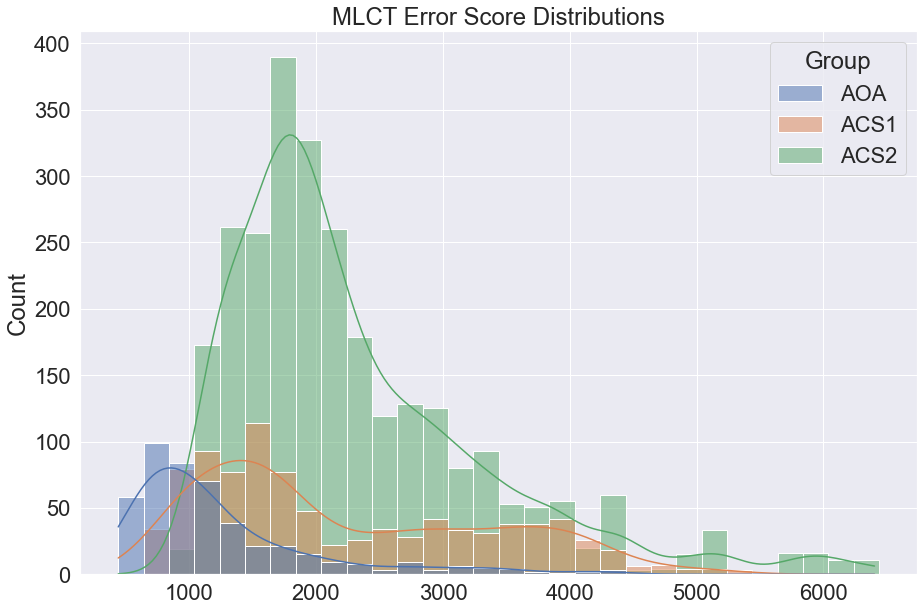

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
# new_df = this_df[['MLCT Error Score', 'Facility']].pivot(columns='Facility')
new_df = this_df[['MLCT Error Score', 'Group']].pivot(columns='Group')
new_df.columns = new_df.columns.droplevel(0)
df = new_df[['AOA', 'ACS1', 'ACS2']]
# df = new_df[['AOA', 'ACS']]
sns.histplot(df, kde=True, binwidth=200, stat='count')
plt.title('MLCT Error Score Distributions')
# plt.xlabel('Error Score')
plt.show()

In [6]:
# fig, ax = plt.subplots(figsize=(15, 10))
frames = [14, 16, 18, 20, 22, 24]


this_df = this_df[this_df['Frame (ms)'] == 14]
# ax = sns.heatmap(data, vmin=0, vmax=1)
init()

def init():
    plt.clf()
    
    new_df = this_df[['MLCT Error Score', 'Group']].pivot(columns='Group')
    new_df.columns = new_df.columns.droplevel(0)
    sns.histplot(new_df[['AOA', 'ACS1', 'ACS2']], kde=True, binwidth=200, stat='percent')
    plt.title('MLCT Error Score Distributions')

def animate(i):
#     plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    this_df = this_df[this_df['Frame (ms)'] == frames[i]]
    new_df = this_df[['MLCT Error Score', 'Group']].pivot(columns='Group')
    new_df.columns = new_df.columns.droplevel(0)
    im = sns.histplot(new_df[['AOA', 'ACS1', 'ACS2']], ax=ax, kde=True, binwidth=200, stat='percent')
#     plt.title('MLCT Error Score Distributions')

anim = animation.FuncAnimation(fig, animate, frames=5, interval=1000, repeat=True)
writervideo = animation.PillowWriter(fps=60)
anim.save('data/test2.gif')
# plt.show()

NameError: name 'init' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
new_df = this_df[['MLCT Std Error Score', 'Facility']].pivot(columns='Facility')
# new_df = this_df[['MLCT Std Error Score', 'Group']].pivot(columns='Group')
new_df.columns = new_df.columns.droplevel(0)
# df = new_df[['AOA', 'ACS1', 'ACS2']]
df = new_df[['AOA', 'ACS']]
sns.histplot(df, kde=True)
plt.title('Adjusted Score Distributions')
plt.xlabel('MLCT Std Error Score')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=this_df, x='Facility', y='Raw Score')
sns.swarmplot(data=this_df, x='Facility', y='Raw Score', color='k', alpha=0.5)
plt.title('Raw Score Comparison')
plt.ylabel('Error Score')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=this_df, x='Facility', y='sigma')
sns.swarmplot(data=this_df, x='Facility', y='sigma', color='k', alpha=0.5)
plt.title('Fraction of Standard Deviations Comparison')
plt.ylabel('Mean Normalized Score')

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 10))
sns.pairplot(this_df[['sigma', 'Rank_noisy', 'Group']], hue='Group', plot_kws={'alpha': 0.5})
fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.title('Rank vs Sigma Score')
# aoa_df_c[['Score', 'Rank']]

In [7]:
g = sns.jointplot(data=this_df[['sigma', 'Rank', 'Group']], 
              x='Rank',
              y='sigma',
              hue='Group',
#               alpha=0.5,
#               kind='kde'
                 )
fig = plt.gcf()
fig.set_size_inches(20, 15)
g.fig.suptitle('MLCT Error Score vs Rank')
g.set_axis_labels(ylabel='MLCT Error Score', xlabel='Rank')

KeyError: "['sigma', 'Rank'] not in index"

Text(0.5, 0, 'TS Rank')

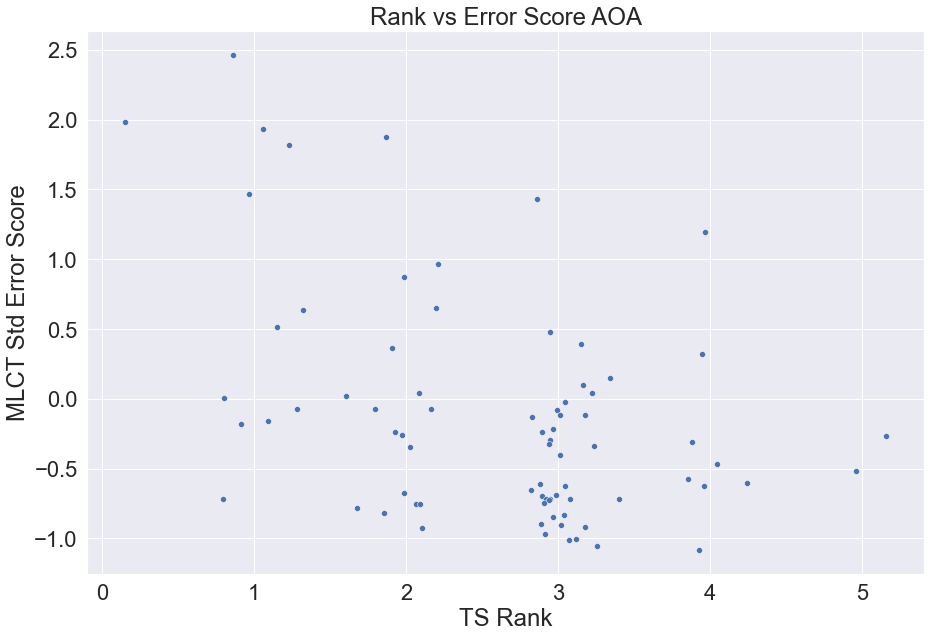

In [8]:
group1_df = this_df[this_df['Group'] == 'AOA']
sns.scatterplot(data=group1_df[['MLCT Std Error Score', 'Rank_noisy']],
                x='Rank_noisy',
                y='MLCT Std Error Score')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title('Rank vs Error Score AOA')
plt.xlabel('TS Rank')

C:\Users\zachary.preator\PycharmProjects\mlct_analysis\venv\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\zachary.preator\PycharmProjects\mlct_analysis\venv\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'TS Rank')

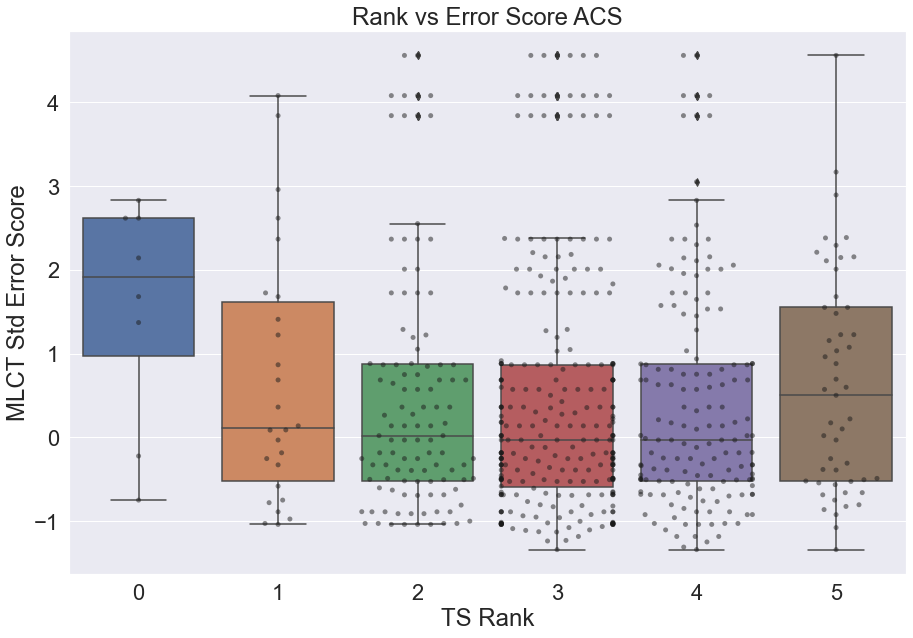

In [13]:
group1_df = this_df[this_df['Facility'] == 'ACS']
sns.swarmplot(data=group1_df[['MLCT Std Error Score', 'TS Rank']],
                x='TS Rank',
                y='MLCT Std Error Score',
                color='k',
                alpha=0.5)
sns.boxplot(data=group1_df[['MLCT Std Error Score', 'TS Rank']],
            x='TS Rank',
            y='MLCT Std Error Score')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title('Rank vs Error Score ACS')
plt.xlabel('TS Rank')

In [ ]:
sns.scatterplot(data=group1_df[['MLCT Std Error Score', 'Rank_noisy']],
                x='Rank_noisy',
                y='MLCT Std Error Score')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title('Rank vs Error Score ACS')

### 1.2 $\bar{X}$ and MR Chart

We'll create a function that takes the dataframe, frame number (in milliseconds), and a time period to group data by. The function will provide an $\bar{X}$ and MR plot. (Mean and Moving Range).

In [ ]:
def x_bar_and_mr(frame, time_period):
#     aoa_df['Facility'] = 'AOA'
#     acs_df['Facility'] = 'ACS'
#     df1 = pd.concat([aoa_df, acs_df])
    
    aoa_df_frame = aoa_df[aoa_df['Frame'] == frame]
    acs_df_1_frame = acs_df_1[acs_df_1['Frame'] == frame]
    acs_df_2_frame = acs_df_2[acs_df_2['Frame'] == frame]
    
    if time_period.lower() == 'all':
        scores_aoa   = aoa_df_frame.copy()
        scores_acs_1 = acs_df_1_frame.copy()
        scores_acs_2 = acs_df_2_frame.copy()
    else:
        scores_aoa =   aoa_df_frame.resample(time_period).mean().dropna()[['Raw Score']]
        scores_acs_1 = acs_df_1_frame.resample(time_period).mean().dropna()[['Raw Score']]
        scores_acs_2 = acs_df_2_frame.resample(time_period).mean().dropna()[['Raw Score']]

    ranges_aoa = scores_aoa.copy()
    ranges_acs_1 = scores_acs_1.copy()
    ranges_acs_2 = scores_acs_2.copy()
    
    ranges_aoa = ranges_aoa.shift(1)
    ranges_acs_1 = ranges_acs_1.shift(1)
    ranges_acs_2 = ranges_acs_2.shift(1)
    
    ranges_aoa['Prev'] = ranges_aoa['Raw Score']
    ranges_acs_1['Prev'] = ranges_acs_1['Raw Score']
    ranges_acs_2['Prev'] = ranges_acs_2['Raw Score']
    
    ranges_aoa['Range'] = scores_aoa['Raw Score'] - ranges_aoa['Prev']
    ranges_acs_1['Range'] = scores_acs_1['Raw Score'] - ranges_acs_1['Prev']
    ranges_acs_2['Range'] = scores_acs_2['Raw Score'] - ranges_acs_2['Prev']

    # Define plot
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10), sharex=True)
    fig.suptitle(r'$\bar{{{0}}}$ & MR chart {1} ms'.format('X', frame), fontsize=20)
    # X Bar chart
    sns.lineplot(ax=ax1, y='Raw Score', x=scores_aoa.index, marker='o', data=scores_aoa, color='k')
    sns.lineplot(ax=ax1, y='Raw Score', x=scores_acs_1.index, marker='o', data=scores_acs_1, color='y')
    sns.lineplot(ax=ax1, y='Raw Score', x=scores_acs_2.index, marker='o', data=scores_acs_2, color='y')
    mean = scores_aoa['Raw Score'].mean()
    cl = 3*scores_aoa['Raw Score'].std()
    ucl = mean + cl
    lcl = mean - cl
    ax1.axhline(scores_aoa['Raw Score'].mean(), color='b')
    ax1.axhline(ucl, color='r', linestyle='dashed')
    ax1.axhline(lcl, color='r', linestyle='dashed')
    ax1.set_ylabel(r'$\bar{{{0}}}$'.format('X'))
    ax1.set_xlabel('')

    # Moving Range chart
    sns.lineplot(ax=ax2, y='Range', x=ranges_aoa.index, marker='o', data=ranges_aoa, color='k')
    sns.lineplot(ax=ax2, y='Range', x=ranges_acs_1.index, marker='o', data=ranges_acs_1, color='y')
    sns.lineplot(ax=ax2, y='Range', x=ranges_acs_2.index, marker='o', data=ranges_acs_2, color='y')
    mean = ranges_aoa['Range'].mean()
    cl = 3*ranges_aoa['Range'].std()
    ucl = mean + cl
    lcl = mean - cl
    ax2.axhline(ranges_aoa['Range'].mean(), color='b')
    ax2.axhline(ucl, color='r', linestyle='dashed')
    ax2.axhline(lcl, color='r', linestyle='dashed')
    ax2.set_ylabel('MR')
    ax2.set_xlabel('Date')
    plt.xticks(rotation=45)
    plt.savefig('xbarmr.png')
#     plt.show()
    print(aoa_df_frame.head())
    
x_bar_and_mr(14, 'all')

In [ ]:
aoa_df.index

In [ ]:
def comparison_graph(orientation, frame, plot_type, split, show_points):
#     front_df = aoa_df.copy()
#     front_df['AOA'] = front_aoa_df['Raw Score']
#     front_df['ACS'] = front_acs_df['Raw Score']
#     front_df['orientation'] = 'Front'
#     front_df = front_df[front_df['Frame'] == frame]
#     front_df_m = pd.melt(front_df[['AOA', 'ACS', 'orientation']], id_vars=['orientation'], var_name='Facility')
    split = False
    
    
#     this_df = pd.concat([front_df_m, side_df_m])
    
#     if orientation.lower() == 'all':
#         pass
#     else:
#         this_df = this_df[this_df['orientation'] == orientation]

    # Plotting section
#     if split == True and orientation.lower() != 'all':
#         print('Orientation:', orientation)
#         print('Error, orientation must be set to All for split plots')
#         return
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    if plot_type == 'violin':
        if split == True:
            sns.violinplot(data=this_df, x='Facility', y='value', hue='orientation', split=True, inner='quart')
            if show_points:
                sns.swarmplot(data=this_df, x='Facility', y='value', color='k', hue='orientation', alpha=0.5, dodge=True)
        else:
            sns.violinplot(data=this_df, x='Facility', y='value', inner='quart')
            if show_points:
                sns.swarmplot(data=this_df, x='Facility', y='value', color='k', alpha=0.5)
    elif plot_type == 'box':
        if split == True:
            sns.boxplot(data=this_df, x='Facility', y='value', hue='orientation')
            if show_points:
                sns.swarmplot(data=this_df, x='Facility', y='value', hue='orientation', color='k', alpha=0.5, dodge=True)
        else:
            sns.boxplot(data=this_df, x='Facility', y='value')
            if show_points:
                sns.swarmplot(data=this_df, x='Facility', y='value', color='k', alpha=0.5)
    
    fig.suptitle(r'Pixel-wise Mean Squared Error at {0} ms'.format(frame), fontsize=20)
    plt.ylabel('Error Score')
    plt.show()
    
# comparison_graph('Front', 10, 'violin', True, True)

This snippet provides a simple user interface to select the frame and time to group the data by. It is defined here, but implemented in section 2.

In [ ]:
dialog_xbmr = widgets.Output()
charts_xbmr = widgets.Output()

frames = aoa_df.sort_values(by='Frame')['Frame'].unique().tolist()
lbl_frame = widgets.Label('Frame Number (ms)')
drop_down_frame_1 = widgets.Dropdown(options = frames)
lbl_orientation = widgets.Label('Orientation (Front/side)')
drop_down_orientation_1 = widgets.Dropdown(options = ['Front', 'Side'])
lbl_time = widgets.Label('Time Period for Resampling')
drop_down_time = widgets.Dropdown(options = [('All', 'all'), ('Day', 'D'), ('Week', 'W'), ('Month', 'M')])
btn = widgets.Button(description='Refresh XBar and MR chart')
label_frames = widgets.VBox([lbl_frame, drop_down_frame_1, lbl_orientation, drop_down_orientation_1])
label_dropdowns = widgets.VBox([lbl_time, drop_down_time])
labels = widgets.HBox([label_frames, label_dropdowns])

def show_chart(b):
    with charts_xbmr:
        charts_xbmr.clear_output()
        x_bar_and_mr(drop_down_orientation_1.value, drop_down_frame_1.value, drop_down_time.value)
            
with dialog_xbmr:
    display(labels)
    display(btn)
    
    btn.on_click(show_chart)

In [ ]:
dialog_comp = widgets.Output()
charts_comp = widgets.Output()

drop_down_frame_2 = widgets.Dropdown(options = frames)
drop_down_orientation_2 = widgets.Dropdown(options = ['All', 'Front', 'Side'])
lbl_plot = widgets.Label('Plot Type')
drop_down_plot = widgets.Dropdown(options = [('Violin', 'violin'), ('Box', 'box')])
# lbl_split = widgets.Label('Split by Orientation')
check_split = widgets.Checkbox(description='Split by Orientation')
# lbl_points = widgets.Label('Show Points')
check_points = widgets.Checkbox(description='Show Points')

btn_comp = widgets.Button(description='Refresh')

labels_1 = widgets.VBox([lbl_frame, drop_down_frame_2, 
                         lbl_orientation, drop_down_orientation_2, 
                         lbl_plot, drop_down_plot])
labels_2 = widgets.VBox([check_split, check_points])
labels = widgets.HBox([labels_1, labels_2])

def show_chart(b):
    with charts_comp:
        charts_comp.clear_output()
        comparison_graph(drop_down_orientation_2.value, 
                         drop_down_frame_2.value, 
                         drop_down_plot.value,
                         check_split.value,
                         check_points.value)
        
with dialog_comp:
    display(labels)
    display(btn_comp)
    
    btn_comp.on_click(show_chart)

### 1.3 T Test

In [ ]:
def t_test(frame, kind):
#     front_df = aoa_df.copy()
#     front_df['AOA'] = front_aoa_df['Raw Score']
#     front_df['ACS'] = front_acs_df['Raw Score']
#     front_df['orientation'] = 'Front'
#     front_df = front_df[front_df['Frame'] == frame]
#     front_df_m = pd.melt(front_df[['AOA', 'ACS', 'orientation']], id_vars=['orientation'], var_name='Facility')

#     side_df = aoa_df.copy()
#     side_df['AOA'] = side_aoa_df['Raw Score']
#     side_df['ACS'] = side_acs_df['Raw Score']
#     side_df['orientation'] = 'Side'
#     side_df = side_df[side_df['Frame'] == frame]
#     side_df_m = pd.melt(side_df[['AOA', 'ACS', 'orientation']], id_vars=['orientation'], var_name='Facility')

#     this_df = pd.concat([front_df_m, side_df_m])
#     this_df = this_df[this_df['orientation'] == orientation]
    this_df = this_df.reset_index()
    display(Markdown(r'### Levene\'s test'))
    display(Markdown(r'Null: $std_{{AOA}} = std_{{ACS}}$'))
    display(Markdown(r'Alternate: $std_{{AOA}} \neq std_{{ACS}}$'))
    display(Markdown(r'### T Test'))
    display(Markdown(r'Null: $\mu_{{AOA}} = \mu_{{ACS}}$'))
    display(Markdown(r'Alternate: $\mu_{{AOA}} \neq \mu_{{ACS}}$'))
    for groups in [['AOA', 'ACS1'], ['AOA', 'ACS2'], ['ACS1', 'ACS2']]:
        a = this_df[this_df['Facility'] == groups[0]]['value'].tolist()
        b = this_df[this_df['Facility'] == groups[1]]['value'].tolist()
        stat, pval = stats.levene(a, b, center=kind)
        
        print('{0}x{1} Levene\'s P Value: {2}'.format(groups[0], groups[1], pval))
        if pval < 0.05:
            print('There is enough evidence to suggest the variance in error scores is significantly different')
#             print('\nIn the t-test, provide FALSE for the Equal Variances parameter')
            equal_var = False
        else:
            print('There is not enough evidence to suggest the variance in error scores is significantly different')
#             print('\nIn the t-test, provide TRUE for the Equal Variances parameter')
            equal_var = True
        stat, pval = stats.ttest_ind(a, b, equal_var = equal_var)
        print('{0}x{1} T-Test P Value: {2}'.format(groups[0], groups[1], pval))
        
levene(14, 'median')

In [ ]:
def t_test(frame, orientation, equal_var):
#     front_df = front_aoa_df.copy()
#     front_df['AOA'] = front_aoa_df['Raw Score']
#     front_df['ACS'] = front_acs_df['Raw Score']
#     front_df['orientation'] = 'Front'
#     front_df = front_df[front_df['Frame'] == frame]
#     front_df_m = pd.melt(front_df[['AOA', 'ACS', 'orientation']], id_vars=['orientation'], var_name='Facility')

    this_df = aoa_df.copy()
    this_df['AOA'] = aoa_df['Raw Score']
    this_df['ACS1'] = acs_df_1['Raw Score']
    this_df['ACS2'] = acs_df_2['Raw Score']
    this_df['orientation'] = 'Side'
    this_df = side_df[side_df['Frame'] == frame]
    this_df = pd.melt(side_df[['AOA', 'ACS1', 'ACS2']], var_name='Facility')
    
    this_df = pd.concat([front_df_m, side_df_m])
    this_df = this_df[this_df['orientation'] == orientation]
    this_df = this_df.reset_index()
    a = this_df[this_df['Facility'] == 'AOA']['value'].tolist()
    b = this_df[this_df['Facility'] == 'ACS']['value'].tolist()
    
    stat, pval = stats.ttest_ind(a, b, equal_var = equal_var)
    display(Markdown(r'Null: $\mu_{{AOA}} = \mu_{{ACS}}$'))
    display(Markdown(r'Alternate: $\mu_{{AOA}} \neq \mu_{{ACS}}$'))
    
t_test(10, 'Front', False)

In [ ]:
dialog_levene = widgets.Output()
dialog_ttest = widgets.Output()
results_levene = widgets.Output()
results_ttest = widgets.Output()

lbl_levene = widgets.Label('Test Type')
lbl_ttest = widgets.Label('Equal Variances')

drop_down_frame_3 = widgets.Dropdown(options = frames)
drop_down_frame_4 = widgets.Dropdown(options = frames)
drop_down_orientation_3 = widgets.Dropdown(options = ['Front', 'Side'])
drop_down_orientation_4 = widgets.Dropdown(options = ['Front', 'Side'])
drop_down_levene = widgets.Dropdown(options = [('Median', 'median'), ('Mean', 'mean'), ('Trimmed', 'trimmed')])
drop_down_ttest = widgets.Dropdown(options = [('True', True), ('False', False)])

btn_levene = widgets.Button(description = 'Calculate')
btn_ttest = widgets.Button(description = 'Calculate')

labels_1 = widgets.VBox([lbl_frame, drop_down_frame_3,
                         lbl_orientation, drop_down_orientation_3])
labels_2 = widgets.VBox([lbl_levene, drop_down_levene])
labels_levene = widgets.HBox([labels_1, labels_2])

labels_3 = widgets.VBox([lbl_frame, drop_down_frame_4,
                         lbl_orientation, drop_down_orientation_4])
labels_4 = widgets.VBox([lbl_ttest, drop_down_ttest])
labels_ttest = widgets.HBox([labels_3, labels_4])

def show_levene(b):
    with results_levene:
        results_levene.clear_output()
        levene(drop_down_frame_3.value,
               drop_down_orientation_3.value,
               drop_down_levene.value)
        
def show_ttest(b):
    with results_ttest:
        results_ttest.clear_output()
        t_test(drop_down_frame_4.value,
              drop_down_orientation_4.value,
              drop_down_ttest.value)

with dialog_levene:
    display(labels_levene)
    display(btn_levene)
    btn_levene.on_click(show_levene)
    
with dialog_ttest:
    display(labels_ttest)
    display(btn_ttest)
    btn_ttest.on_click(show_ttest)


<a id='results'></a>
## 2 Results 

### 2.1 $\bar{X}$ and MR Chart

In [ ]:
display(dialog_xbmr)
display(charts_xbmr)

### 2.2 Comparison Charts

In [ ]:
display(dialog_comp)
display(charts_comp)

### 2.3 Independent Sample T Test

**Null Hypothesis:**
- AOA and ACS error score means are equal, meaning there is no significant difference in deployments

**Alternate Hpyothesis:**
- AOA and ACS error score means are not equal, meaning there is enough evidence to suggest difference in deployments

### 2.3.1 Equal Variance

We will first determine if the populations have the same variance. To do so, we can use the ***Levene Test for Equal Variances***. This can be run with median, mean or trimmed (for populations with large tails).

In [ ]:
display(dialog_levene)
display(results_levene)

### 2.3.2 T Test

If the levene result p-value was less than 0.05, then there is enough evidence to suggest that the variances are significantly different. Otherwise, we assume the variances are the same.

In the Independent T Test, we can specify whether the variances are equal.

In [ ]:
display(dialog_ttest)
display(results_ttest)

If the p-value is less than 0.05, then there is enough evidence to reject the null, and suggest that the population means are different. Otherwise, we fail to reject, and state that there is not enough evidence to 